## Task_8. Python применение статистических критериев на практике - пайплайн оценки A/B

### На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [192]:
from scipy import stats
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Подготовка данных.

In [193]:
data = pd.read_excel('./files/AB_Test_Results.xlsx')

In [194]:
data

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [195]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [196]:
data.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [197]:
data.describe(include= 'all')

,USER_ID,VARIANT_NAME,REVENUE
count,10000.000000,10000,10000.000000
unique,NaN,2,NaN
top,NaN,variant,NaN
freq,NaN,5016,NaN
mean,4981.080200,NaN,0.099447
std,2890.590115,NaN,2.318529
min,2.000000,NaN,0.000000
25%,2468.750000,NaN,0.000000
50%,4962.000000,NaN,0.000000
75%,7511.500000,NaN,0.000000


In [198]:
# Поиск пропусков в данных
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [199]:
# Проверка на баг (минусовые значения)
data[data['REVENUE'] < 0].value_counts()

Series([], Name: count, dtype: int64)

In [200]:
# Проверим попал ли пользователь в контрольную и тестовую группу.
id_variants = data.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique})
id_variants

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
...,...,...
6319,9993,1
6320,9995,1
6321,9996,2
6322,9998,1


In [201]:
# Колличество уникальных пользователей попавших в 1 и в обе группы. 
id_variants.VARIANT_NAME.value_counts()

VARIANT_NAME
1    4783
2    1541
Name: count, dtype: int64

In [202]:
# ~ 1/4 от всех пользователей попала в обе группы
id_variants.VARIANT_NAME.value_counts(normalize=True)

VARIANT_NAME
1    0.756325
2    0.243675
Name: proportion, dtype: float64

In [203]:
# Колличество уникальных пользователей.
data.USER_ID.nunique()

6324

In [204]:
# Удаляем дубликаты
data_unique =  data.drop_duplicates(subset=['USER_ID'])

In [205]:
# Проверяем количество платящих пользователей в данных 
data['USER_ID'][data['REVENUE'] > 0].count()

152

In [206]:
# Проверяем количество платящих пользователей в данных с удаленными дубликатами
data_unique['USER_ID'][data_unique['REVENUE'] > 0].count()

90

Пользователи попавшие в обе группы некорректно влияют на тест.

In [207]:
# Удаляем пользователей с базы. (~0,24% от уникальных пользователей)
id_2_variants = id_variants.query('VARIANT_NAME > 1')
data_new = data[~data.USER_ID.isin(id_2_variants.USER_ID)].sort_values('USER_ID')

In [208]:
percent = data_new.USER_ID.count()/data.USER_ID.count()*100
print(f'Процент данных, оставшийся для анализа - {percent:.2f}%')

Процент данных, оставшийся для анализа - 60.70%


In [209]:
data_new.describe()

,USER_ID,REVENUE
count,6070.000000,6070.000000
mean,4983.664086,0.107064
std,2897.990118,2.673501
min,2.000000,0.000000
25%,2472.250000,0.000000
50%,4950.000000,0.000000
75%,7501.000000,0.000000
max,9998.000000,196.010000


Сводная статистика по группам.

In [210]:
group_control = data_new[data_new.VARIANT_NAME == 'control']
group_control.describe()

,USER_ID,REVENUE
count,3026.000000,3026.000000
mean,4990.392928,0.155506
std,2919.665981,3.708620
min,2.000000,0.000000
25%,2457.750000,0.000000
50%,4949.500000,0.000000
75%,7603.750000,0.000000
max,9998.000000,196.010000


In [211]:
group_variant = data_new[data_new.VARIANT_NAME == 'variant']
group_variant.describe()

,USER_ID,REVENUE
count,3044.000000,3044.000000
mean,4976.975033,0.058909
std,2876.744694,0.760344
min,4.000000,0.000000
25%,2487.250000,0.000000
50%,4950.000000,0.000000
75%,7376.500000,0.000000
max,9995.000000,23.040000


### Проверяем данные на нормальное распределение.

In [212]:
from scipy.stats import shapiro

In [213]:
alpha = 0.05
test = shapiro(data_new.REVENUE)

print('Распределение {}нормальное\n'.format({True:'не', False:''}[test[1] < alpha]));

Распределение ненормальное



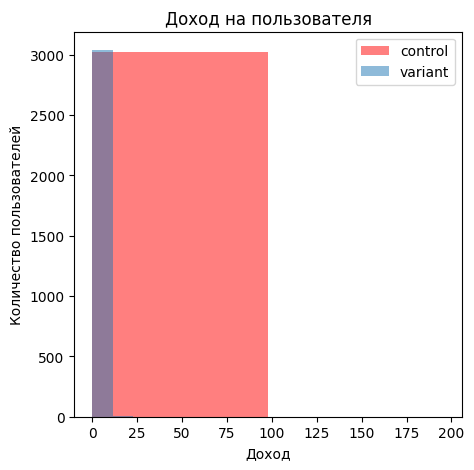

In [214]:
plt.figure(figsize=(5,5))

plt.hist(group_control.REVENUE, color='r', bins=2, alpha=0.5, label='control')
plt.hist(group_variant.REVENUE, bins=2, alpha=0.5, label='variant')

plt.title('Доход на пользователя')
plt.xlabel('Доход')
plt.ylabel('Количество пользователей')
plt.legend();

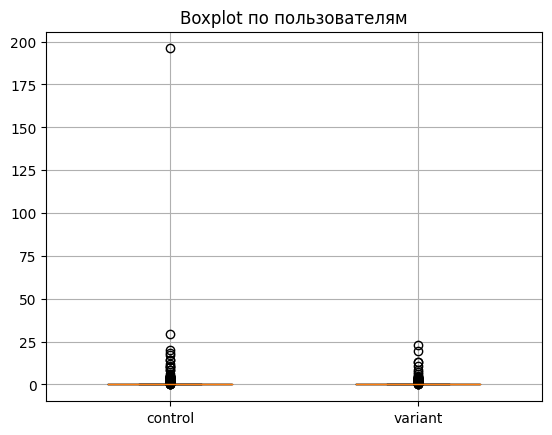

In [215]:
plt.boxplot([group_control.REVENUE, group_variant.REVENUE], labels=['control','variant'], widths=0.5)

plt.title('Boxplot по пользователям')
plt.grid(axis='both');

Зафиксированы вылеты в контрольной группе

#### Проводим проверку на статистическое различие данных

Используем тест __Манна-Уитни__, так как:
* Revenue (доход) - непрерывная переменная
* Выборки независимые
* Распределение ненормальное

In [216]:
alpha = 0.05

test_mw = stats.mannwhitneyu(group_control.REVENUE.values, group_variant.REVENUE.values)
test_mw

MannwhitneyuResult(statistic=4622832.0, pvalue=0.2444173738649208)

Pvalue > alpha (0.24 > 0.05), статистическич различий по доходу в группах нет.

#### Проверим конверсию в покупку в группах

In [217]:
# Колличество покупок в группах
k1 = group_control[group_control['REVENUE'] > 0]['REVENUE'].count()
k2 = group_variant[group_variant['REVENUE'] > 0]['REVENUE'].count()
print(f'control = {k1}, variant = {k2}')

control = 54, variant = 43


In [218]:
# Ver_2
k_1 = group_control.query('REVENUE > 0').shape[0]
k_2 = group_variant.query("REVENUE > 0").shape[0]
k_1, k_2

(54, 43)

In [219]:
# Колличество клиентов
n1 = group_control.shape[0]
n2 = group_variant.shape[0]
print(f'control = {n1}, variant = {n2}')

control = 3026, variant = 3044


In [220]:
print('Конверсия в группе: control - %.2f, variant - %.2f'%(k1/n1*100, k2/n2*100))

Конверсия в группе: control - 1.78, variant - 1.41


Используем тест __Хи-квадрат Пирсона__, так как:

* Конверсия относится к типу данных - *качественные (раноговые 0-1)*
* Независимые (рандомно взятые пользователи)
* Cравнивается 2 группы

In [221]:
from statsmodels.stats import proportion

In [222]:
# Тест Хи-квадрат для конверсии в покупку

chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), np.array([n1, n2]))

print('Results are ','chisq =%.3f, pvalue = %.3f'%(chisq, pvalue))

Results are  chisq =1.335, pvalue = 0.248


pvalue > 0.05 -> по метрике конверсия статистических раличий нет

Так как выборка большая, так же подходит __Z-тест__.

In [223]:
z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), np.array([n1, n2]))

print('Results are ','z_score =%.3f, pvalue = %.3f'%(z_score, z_pvalue))

Results are  z_score =1.155, pvalue = 0.248


#### Вывод: 
В данных ~0,24% от уникальных пользователей попали в контрольную и тестируемую группу.<p>
Пользователи попавшие в обе группы некорректно влияют на тест.<p>
Анализ произведен на обработанных данных ~60.70%, без учета этих пользователей.

* Среднее по доходу в контрольной группе больше - 0,15% vs 0,05%, но присутствуют вылеты.
* Конверсия в покупку в контрольной группе выше - 1,78% vs 1,43%.
* Статистических различий по доходу в группах нет.
* Статистических различий по конверсии в покупку в группах нет.

Так как статистических различий между контрольной и тестируемой группой нет, оставляем без изменений.